In [7]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from logic_features import GenerateFeatures
from essentials import two_class_labels, normalize

In [8]:
with open('data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimates_dict = pickle.load(f)
with open('data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)

In [ ]:
labelled_imu_dict = {}
for i_void_instance, void_instance in tqdm(enumerate(imu_dict.keys()), desc="Adding labels to IMU data"):
    acc = imu_dict[void_instance]
    gt = ground_truth_dict[void_instance]
    
    # # normalize data
    df = normalize(acc)
    
    # add the labels
    labelled_df = two_class_labels(acc, gt)
    
    # remove the gyr data
    labelled_df.drop(columns=['gyr_x', 'gyr_y', 'gyr_z'], axis = 1, inplace=True)
    labelled_imu_dict[void_instance] = labelled_df

Adding labels to IMU data: 43it [00:00, 289.12it/s]


In [10]:
all_features = []
#  do not upsample
features_per_experiment = {}
for exp_id, imu_data in enumerate(imu_dict.keys()):    
    # Extract features
    
    df = labelled_imu_dict[imu_data]
    fs = 1 / df['time'].diff().mean()
    analyzer = GenerateFeatures(fs, window_duration=1.0, overlap=0.8)
    features, _ = analyzer.analyze_multi_axis_imu(labelled_imu_dict[imu_data])

    table = analyzer.create_summary_table()
    table['experiment_id'] = exp_id + 1  # Track source
    all_features.append(table)
    
    features_per_experiment[imu_data] = table
final_features = pd.concat(all_features, ignore_index=True)

Analyzing : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


In [24]:
final_features.head()

,center_time,start_time,end_time,acc_x_permutation_entropy,acc_x_spectral_entropy,acc_x_mean,acc_x_std,acc_x_range,acc_x_rms,acc_x_var,...,acc_mag_std,acc_mag_range,acc_mag_rms,acc_mag_var,acc_mag_min,acc_mag_max,acc_mag_time_energy,acc_mag_spectral_energy,label,experiment_id
0,0.499593,0.000000,0.999186,0.840598,0.524760,0.938842,1.134729,5.349532,1.472764,1.287610,...,0.950861,4.338769,1.989574,0.904136,0.107588,4.446357,233.545858,13779.205614,non-void,1
1,0.685882,0.186289,1.185475,0.833607,0.520173,0.989449,1.158952,5.349532,1.523870,1.343169,...,0.974930,4.338769,1.987275,0.950488,0.107588,4.446357,233.006397,13747.377440,non-void,1
2,0.872171,0.372578,1.371763,0.823753,0.562236,1.193638,1.186426,5.349532,1.682967,1.407606,...,1.031948,4.338769,2.169826,1.064918,0.107588,4.446357,277.780664,16389.059150,non-void,1
3,1.058459,0.558867,1.558052,0.837070,0.566957,1.251707,1.200011,5.349532,1.734012,1.440027,...,1.012218,4.338769,2.173449,1.024585,0.107588,4.446357,278.708959,16443.828570,non-void,1
4,1.244748,0.745155,1.744341,0.815424,0.582808,1.165694,1.210199,5.349532,1.680305,1.464581,...,1.084391,4.338769,2.106941,1.175903,0.107588,4.446357,261.912788,15452.854511,non-void,1


Classify based on the variance of the triaxial accelerometer.

In [11]:
preds = []
for index, row in final_features.iterrows():
    if (-0.5 <= row['acc_x_var'] <= 1) and (-0.5 <= row['acc_y_var'] <= 0.5) and (-0.5 <= row['acc_z_var'] <= 0.5):
        preds.append('void')
    else:
        preds.append('non-void')

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# plot the confusion matrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
    cm_df = pd.DataFrame(cm, index=sorted(set(y_true)), columns=sorted(set(y_true)))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

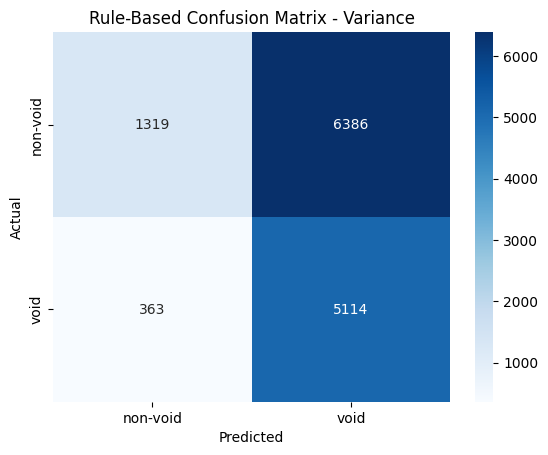

In [13]:
y_true = np.array(final_features['label'])
plot_confusion(y_true, preds, "Rule-Based Confusion Matrix - Variance")

The void class is expected to have less motion (standing still or sitting still).
Variance looks like a good feature to detect the periods of inactivity - void window.

Classify based on the mean of the triaxial accelerometer.

In [14]:
preds = []
for index, row in final_features.iterrows():
    if (-0 <= row['acc_x_mean'] <= 1) and (-1 <= row['acc_y_mean'] <= 0) and (-1 <= row['acc_z_mean'] <= 0):
        preds.append('void')
    else:
        preds.append('non-void')

In [15]:
# plot the confusion matrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
    cm_df = pd.DataFrame(cm, index=sorted(set(y_true)), columns=sorted(set(y_true)))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

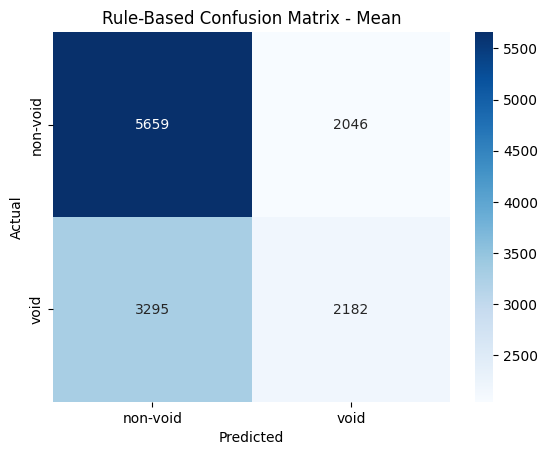

In [16]:
y_true = np.array(final_features['label'])
plot_confusion(y_true, preds, "Rule-Based Confusion Matrix - Mean")

## Combined

In [17]:
def rule_based_classifier(row):
    is_low_var = (-0.5 <= row['acc_x_var'] <= 1) and (-0.5 <= row['acc_y_var'] <= 0.5) and (-0.5 <= row['acc_z_var'] <= 0.5)
    is_mean_posture = (-0.6 <= row['acc_x_mean'] <= 1) and (-1 <= row['acc_y_mean'] <= 0) and (-1 <= row['acc_z_mean'] <= 0)

    if is_low_var and is_mean_posture:
        return 'void'
    else:
        return 'non-void'

In [18]:
preds = []
for index, row in final_features.iterrows():
    preds.append(rule_based_classifier(row))

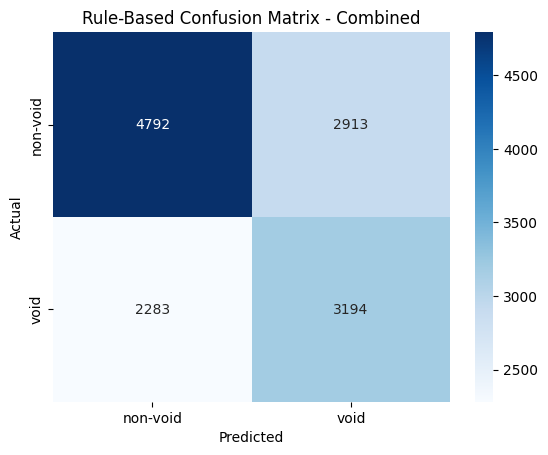

In [19]:
y_true = np.array(final_features['label'])
plot_confusion(y_true, preds, "Rule-Based Confusion Matrix - Combined")

## Basic Decision tree


In [25]:
# Select features and labels
X = final_features[['acc_x_mean', 'acc_y_mean', 'acc_z_mean', 'acc_x_var', 'acc_y_var', 'acc_z_var']]
y = final_features['label']


In [27]:
from sklearn.model_selection import GroupShuffleSplit
groups = final_features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text


# Fit a decision tree
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [29]:
from sklearn.tree import export_text

tree_rules = export_text(tree_clf, feature_names=list(X.columns))
print(tree_rules)

|--- acc_x_var <= 0.13
|   |--- acc_x_mean <= -1.08
|   |   |--- acc_z_mean <= -1.20
|   |   |   |--- class: void
|   |   |--- acc_z_mean >  -1.20
|   |   |   |--- class: non-void
|   |--- acc_x_mean >  -1.08
|   |   |--- acc_y_var <= 0.00
|   |   |   |--- class: void
|   |   |--- acc_y_var >  0.00
|   |   |   |--- class: non-void
|--- acc_x_var >  0.13
|   |--- acc_y_var <= 0.16
|   |   |--- acc_y_var <= 0.04
|   |   |   |--- class: non-void
|   |   |--- acc_y_var >  0.04
|   |   |   |--- class: non-void
|   |--- acc_y_var >  0.16
|   |   |--- acc_x_var <= 0.28
|   |   |   |--- class: non-void
|   |   |--- acc_x_var >  0.28
|   |   |   |--- class: non-void



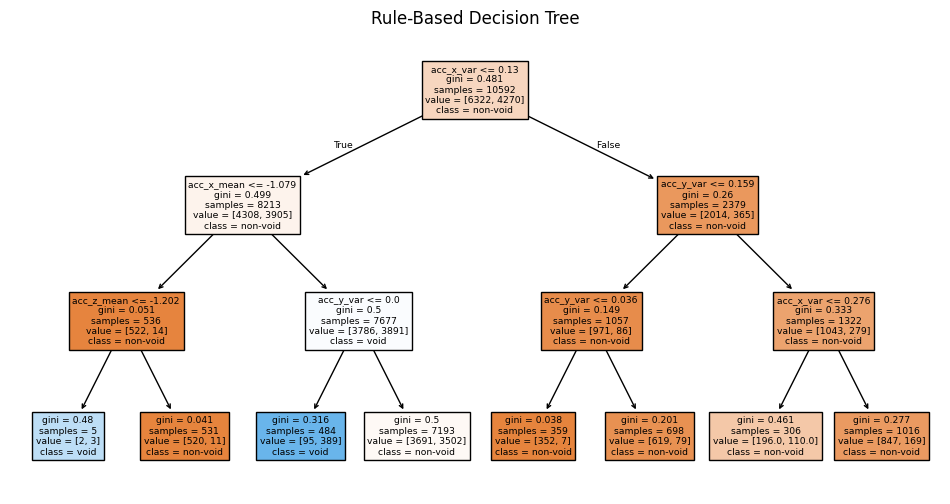

In [30]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
tree.plot_tree(tree_clf, feature_names=X.columns, class_names=['non-void', 'void'], filled=True)
plt.title("Rule-Based Decision Tree")
plt.show()

In [31]:
y_pred = tree_clf.predict(X_test)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    non-void       0.54      0.99      0.70      1383
        void       0.65      0.01      0.02      1207

    accuracy                           0.54      2590
   macro avg       0.59      0.50      0.36      2590
weighted avg       0.59      0.54      0.38      2590



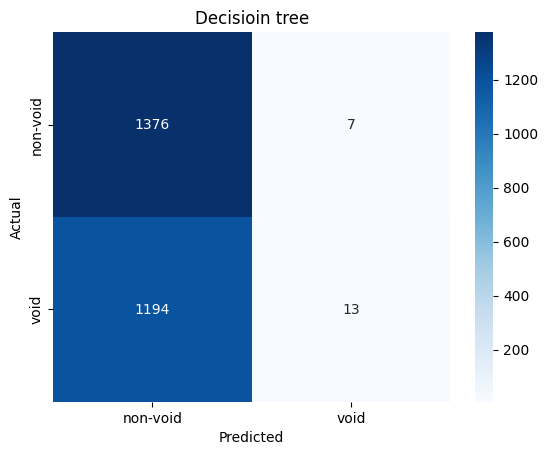

In [33]:
plot_confusion(y_test, y_pred, "Decisioin tree")